In [1]:
from multi_agents.graph.builder import GraphBuilder
import asyncio
from multi_agents.graph.state import AgentState
import logging



[MongoTraceSink] 🟡 Attempting to connect to MongoDB cluster: cluster0.szb4tfi.mongodb.net/?retryWrites=true&w=majority&appName=Cluster0
[MongoTraceSink] ✅ MongoDB connection successful. Tracing is ENABLED.
[MongoTraceSink] ⚙️  Ensured indexes on 'multi_agents_results.traces' collection.


INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Successfully loaded faiss with AVX2 support.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


In [2]:
graph_builder = GraphBuilder()


[MongoTraceSink] 🟡 Attempting to connect to MongoDB cluster: cluster0.szb4tfi.mongodb.net/?retryWrites=true&w=majority&appName=Cluster0
[MongoTraceSink] ✅ MongoDB connection successful. Tracing is ENABLED.
[MongoTraceSink] ⚙️  Ensured indexes on 'multi_agents_results.traces' collection.


In [3]:
graph_builder

In [4]:
app = graph_builder.build_graph()

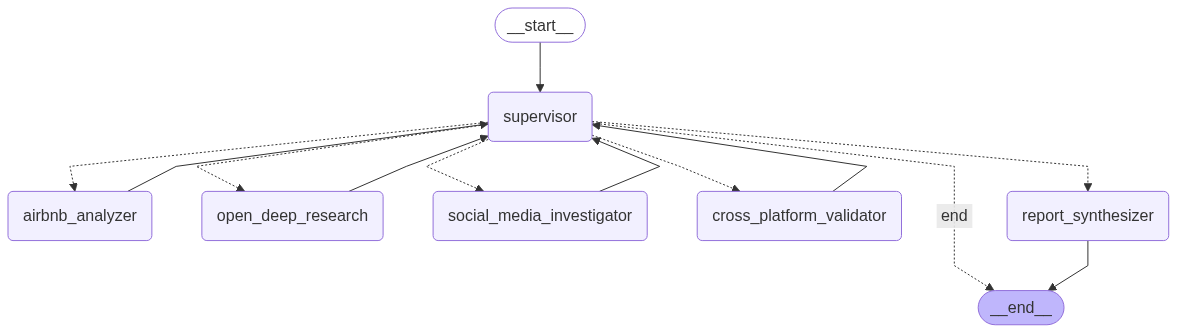

In [5]:
app

In [6]:
import logging
import sys

# Get the specific logger for the deep research agent
dr_logger = logging.getLogger("multi_agents.open_deep_research")
dr_logger.setLevel(logging.INFO) # We still want to see the messages

# Create a handler that prints to your console
simple_handler = logging.StreamHandler(sys.stdout)

# Create a formatter that ONLY prints the message, without any prefixes
simple_formatter = logging.Formatter('%(message)s')
simple_handler.setFormatter(simple_formatter)

# CRITICAL: Replace the old handlers with our new, simple one
dr_logger.handlers = [simple_handler]
dr_logger.propagate = False 

In [ ]:
import asyncio
from multi_agents.graph.builder import GraphBuilder
from multi_agents.agents.supervisor import Supervisor

graph_builder = GraphBuilder()
app = graph_builder.build_graph()
sup = Supervisor()

query = "Find the online identity of the hoster at https://www.airbnb.com/users/show/698886341"
state = {
    "original_query": query,
    "plan": [],
    "past_steps": [],
    "aggregated_results": {},
    "final_report": "",
    "messages": [],
    "last_step_result": None,
    "last_step_message": None,
    "awaiting_user_confirmation": False,
    "candidate_options": [],
    "selected_candidate": None,
}

async def run_with_hitl(app, state):
    while True:
        state = await app.ainvoke(state)

        print("\n--- step done ---")
        print("Next plan:", state.get("plan"))

        # If a worker set the pause flag BEFORE supervisor processed the result,
        # we may have no candidates yet. Give the graph another tick to let
        # the Supervisor aggregate outputs and surface candidate_options.
        while state.get("awaiting_user_confirmation") and not state.get("candidate_options"):
            state = await app.ainvoke(state)

        # Now handle HITL if present
        if state.get("awaiting_user_confirmation"):
            cands = state.get("candidate_options", [])
            # If still empty, we can bail or just auto-continue
            if not cands:
                print("Pause requested but no candidates were provided. Auto-resuming.")
                # Clear the pause so we can continue
                state["awaiting_user_confirmation"] = False
                continue

            print("\nHuman disambiguation required. Candidates:")
            for i, c in enumerate(cands):
                print(f" [{i}] {c.get('platform')} | {c.get('name')} | {c.get('url')}\n     why: {c.get('why')}")

            # pick one (replace with input() in a plain console env)
            try:
                idx = int(input("\nPick candidate index: "))
            except Exception:
                idx = 0

            state = sup.ingest_user_selection(state, idx)

            # If the worker paused BEFORE supervisor popped the step,
            # the plan may still begin with the just-completed agent.
            # Defensive pop to avoid re-running the same step:
            if state.get("plan") and isinstance(state["plan"], list):
                if state["plan"][0].get("agent") == "airbnb_analyzer":
                    state["plan"].pop(0)

            # Continue the loop to resume graph
            continue

        # If we produced a final report, or the plan is empty and no pause, we’re done
        if state.get("final_report"):
            print("\nFINAL REPORT (snippet):\n", (state["final_report"] or "")[:800])
            return state

        if not state.get("plan") and not state.get("awaiting_user_confirmation"):
            return state

# If in Jupyter, do:
final_state = await run_with_hitl(app, state)
# If in a script, wrap with asyncio.run(...)



[MongoTraceSink] 🟡 Attempting to connect to MongoDB cluster: cluster0.szb4tfi.mongodb.net/?retryWrites=true&w=majority&appName=Cluster0
[MongoTraceSink] ✅ MongoDB connection successful. Tracing is ENABLED.
[MongoTraceSink] ⚙️  Ensured indexes on 'multi_agents_results.traces' collection.

[MongoTraceSink] 🟡 Attempting to connect to MongoDB cluster: cluster0.szb4tfi.mongodb.net/?retryWrites=true&w=majority&appName=Cluster0
[MongoTraceSink] ✅ MongoDB connection successful. Tracing is ENABLED.
[MongoTraceSink] ⚙️  Ensured indexes on 'multi_agents_results.traces' collection.


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.agents.supervisor:Supervisor re-architected the plan: [{'agent': 'airbnb_analyzer', 'inputs': {'url': 'https://www.airbnb.com/users/show/698886341', 'profile_url': 'Find the online identity of the hoster at https://www.airbnb.com/users/show/698886341'}}]
INFO:multi_agents.agents.supervisor:[Supervisor] Next plan: [{'agent': 'airbnb_analyzer', 'inputs': {'url': 'https://www.airbnb.com/users/show/698886341', 'profile_url': 'Find the online identity of the hoster at https://www.airbnb.com/users/show/698886341'}}]




> Entering new AgentExecutor chain...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find the online identity of the hoster at https://www.airbnb.com/users/show/698886341, I need to gather as much information as possible from the Airbnb database. The get_host_all tool seems to be the most suitable for this task, as it returns everything we know about a host from the DB, including core profile row, listings, listings_detailed, ALL reviews, guidebooks, travels, and listing pictures.

Action: get_host_all
Action Input: {"host": "https://www.airbnb.com/users/show/698886341"}{'status': 'ok', 'userId': '698886341', 'core': {'userId': '698886341', 'userUrl': 'https://www.airbnb.com/users/show/698886341', 'name': 'Hassan', 'isSuperhost': 0, 'isVerified': 1, 'ratingAverage': 4.88, 'ratingCount': 8, 'years': 0, 'months': 0, 'total_listings': 1, 'profile_url': 'https://www.airbnb.com/users/show/698886341', 'scraping_time': 1756570232, 'profile_photo_url': 'https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720', 'abou

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


 I have successfully gathered all the required information from the Airbnb database. I have the host's name, bio, profile picture URL, a list of their property URLs, and reviewer details. Now, I will format this data into the required three-part structure for my final answer.

Final Answer:
### Detailed Summary
The host's name is Hassan, and he is a French teacher from Tangier, Morocco. He has a single listing on Airbnb, which is a well-maintained and clean apartment. The overall sentiment of the reviews is positive, with guests frequently praising Hassan's communication, the cleanliness of the property, and its ideal location. Hassan is described as a kind, polite, and cultured individual who is always available to guide his guests and answer their questions.

### Actionable Intelligence
- **Host Name:** Hassan
- **Profile Picture URL:** https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720
- **Listing URLs:**
  - https://www.airbnb.

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.agents.supervisor:Supervisor re-architected the plan: [{'agent': 'open_deep_research', 'inputs': {'query': 'Hassan French teacher Tangier', 'profile_picture_url': 'https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720', 'airbnb_listing_urls': ['https://www.airbnb.com/rooms/1464489937221305511'], 'airbnb_reviewer_names': ['Omar from Unknown', 'Abdelkader from Vernouillet, France', 'Rabia from Helmond, Netherlands', 'Youssef from Lyon, France', 'Rafa from Unknown', 'Zakaria from Unknown', 'Hamdi from Unknown', 'Nadou from Unknown'], 'context_summary': '{"host_name":"Hassan", "listing_count":1, "review_count":8}'}}]
INFO:multi_agents.agents.supervisor:[Supervisor] Next plan: [{'agent': 'open_deep_research', 'inputs': {'query': 'Hassan 



> Entering new LangGraph chain...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:openai._base_client:Retrying request to /chat/completions in 0.483947 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:multi_agents.agents.supervisor:Supervisor re-architected the plan: [{'agent': 'open_deep_research', 'inputs': {'query': 'Hassan French teacher Tangier', 'profile_picture_url': 'https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720', 'airbnb_listing_urls': ['https://www.airbnb.com/rooms/1464489937221305511'], 'airbnb_reviewer_names': ['Omar from Unknown', 'Abdelkader from Vernouillet, France', 'Rabia from Helmond, Netherlands', 'Youssef from Lyon, France', 'Rafa from Unknown', 'Zakaria from Unknown', 'Hamdi from Unknown', 'Nadou from Unknown'], 'context_summary': '{"host_n


--- step done ---
Next plan: [{'agent': 'open_deep_research', 'inputs': {'query': 'Hassan French teacher Tangier', 'profile_picture_url': 'https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720', 'airbnb_listing_urls': ['https://www.airbnb.com/rooms/1464489937221305511'], 'airbnb_reviewer_names': ['Omar from Unknown', 'Abdelkader from Vernouillet, France', 'Rabia from Helmond, Netherlands', 'Youssef from Lyon, France', 'Rafa from Unknown', 'Zakaria from Unknown', 'Hamdi from Unknown', 'Nadou from Unknown'], 'context_summary': '{"host_name":"Hassan", "listing_count":1, "review_count":8}'}}]


INFO:multi_agents.agents.supervisor:[Supervisor] Next plan: [{'agent': 'open_deep_research', 'inputs': {'query': 'Hassan French teacher Tangier', 'profile_picture_url': 'https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720', 'airbnb_listing_urls': ['https://www.airbnb.com/rooms/1464489937221305511'], 'airbnb_reviewer_names': ['Omar from Unknown', 'Abdelkader from Vernouillet, France', 'Rabia from Helmond, Netherlands', 'Youssef from Lyon, France', 'Rafa from Unknown', 'Zakaria from Unknown', 'Hamdi from Unknown', 'Nadou from Unknown'], 'context_summary': '{"host_name":"Hassan", "listing_count":1, "review_count":8}'}}]
INFO:multi_agents.agents.supervisor:[Supervisor] Next plan: [{'agent': 'open_deep_research', 'inputs': {'query': 'Hassan French teacher Tangier', 'profile_picture_url': 'https://a0.muscache.com/im/pictures/user/User/original/e925659d-c53f-4d10-a029-65113eb66ace.jpeg?im_w=720', 'airbnb_listing_urls': ['https://www.airbnb

In [ ]:

print("\nFinal Report:")
print(final_state.get("final_report", "No report generated"))

# Running kernel 

In [ ]:
from multi_agents.run_interactive import run_interactive

def selection_provider(state):
    # Candidate-based pauses (HITL from workers)
    candidates = state.get("candidate_options") or []
    if candidates:
        print("\nCandidates found:")
        for i, c in enumerate(candidates):
            print(f"[{i}] {c.get('name')} — {c.get('platform','?')} — {c.get('url','')}")
        while True:
            try:
                raw = input("Pick a candidate index (or blank to skip): ").strip()
                return int(raw) if raw != "" else None
            except Exception:
                print("Invalid input, try again.")
    # Judge-only pauses
    msgs = [m.content for m in state.get("messages", []) if getattr(m, "content", None)]
    q = None
    for m in reversed(msgs):
        if m.startswith("Human input required:"):
            q = m
            break
    if q:
        print("\n" + q)
        input("Press Enter to continue...")
    return None

query = "Find the online identity of the host at https://www.airbnb.com/users/show/532236013"
cfg = {"configurable": {
  "max_total_serp_calls": 6,
  "max_researcher_iterations": 6,
  "max_tool_calls_per_turn": 2,
  "search_timeout_seconds": 10
}}
final_state = run_interactive(query, selection_provider=selection_provider, max_global_steps=30, config=cfg)
print("\nFinal report:\n", final_state.get("final_report", "No report generated"))